In [1]:
# https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/

import pandas as pd
# import pandas.io.data as web   # Package and modules for importing data; this code may change depending on pandas version
from pandas_datareader import data as web
import datetime
 
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = web.DataReader("AAPL", "yahoo", start, end)
 
type(apple)
apple.head(1)

ImportError: cannot import name 'is_list_like'

In [ ]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL


In [ ]:
apple.head(4)
apple.columns
apple.index

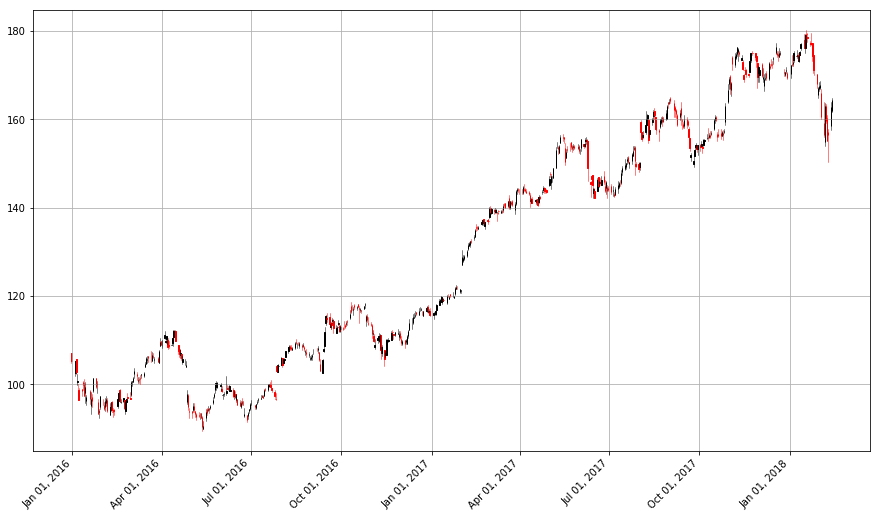

In [4]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

In [5]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2015-12-31,100.927895,758.880005,52.818901
2016-01-04,101.014183,741.840027,52.171520
2016-01-05,98.482841,742.580017,52.409531
2016-01-06,96.555573,743.619995,51.457489
2016-01-07,92.480476,726.390015,49.667664


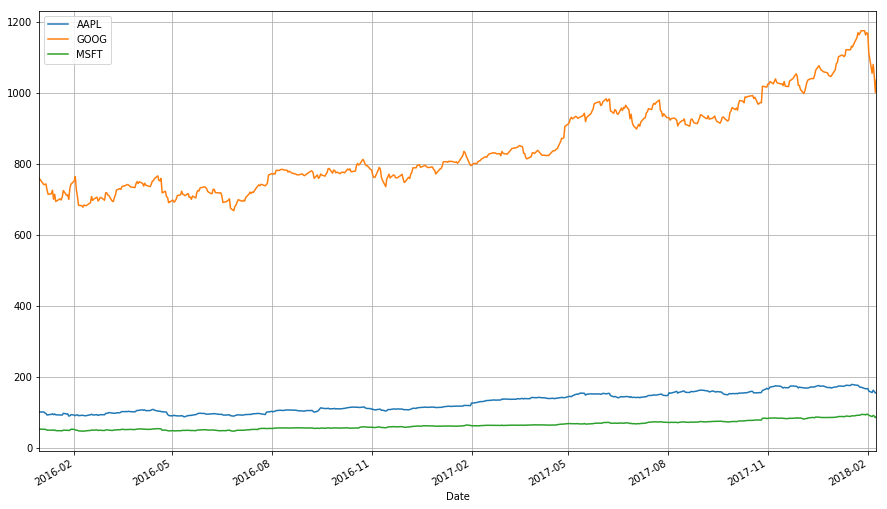

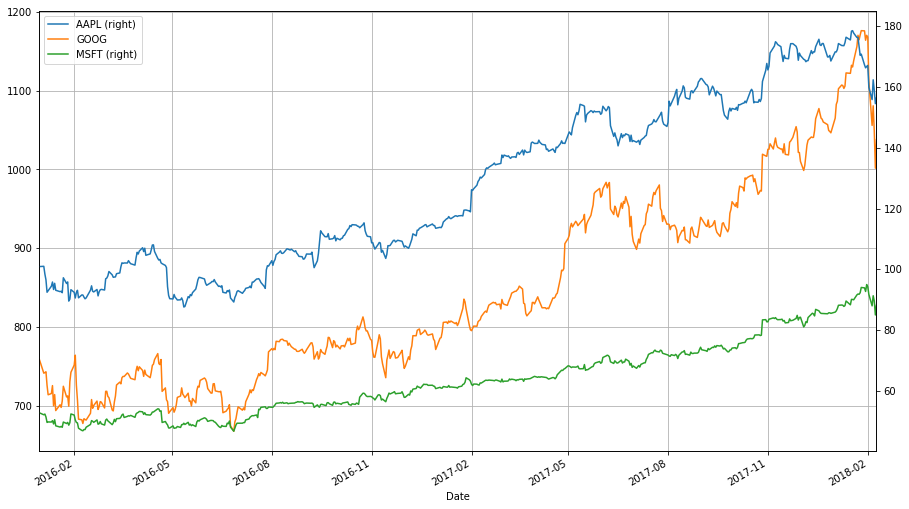

In [9]:
stocks.plot(grid = True)
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

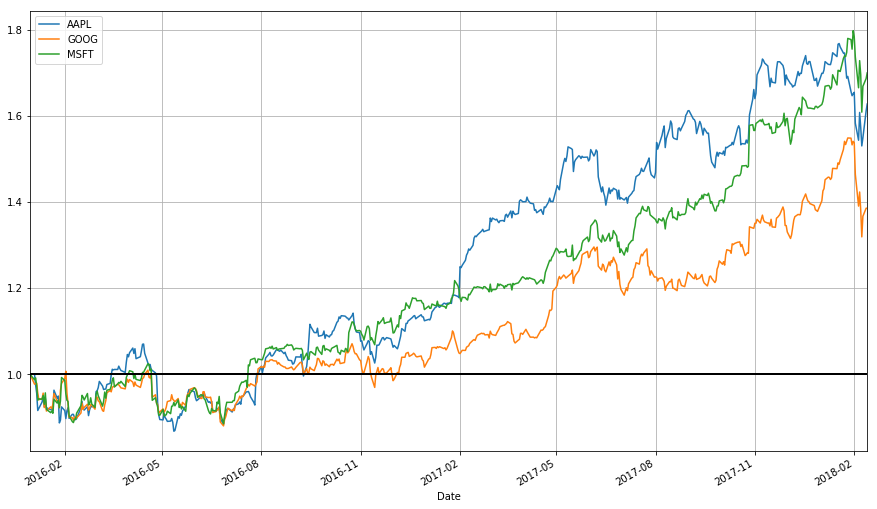

In [6]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)


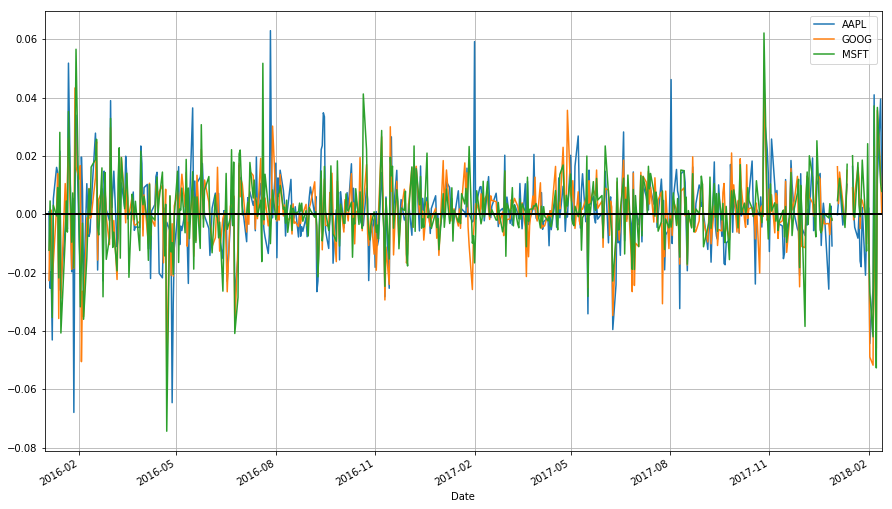

In [10]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

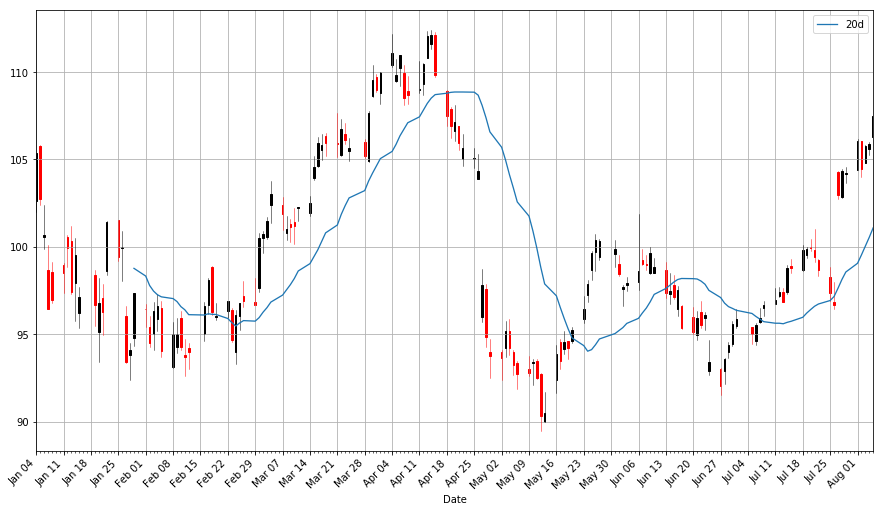

In [11]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")


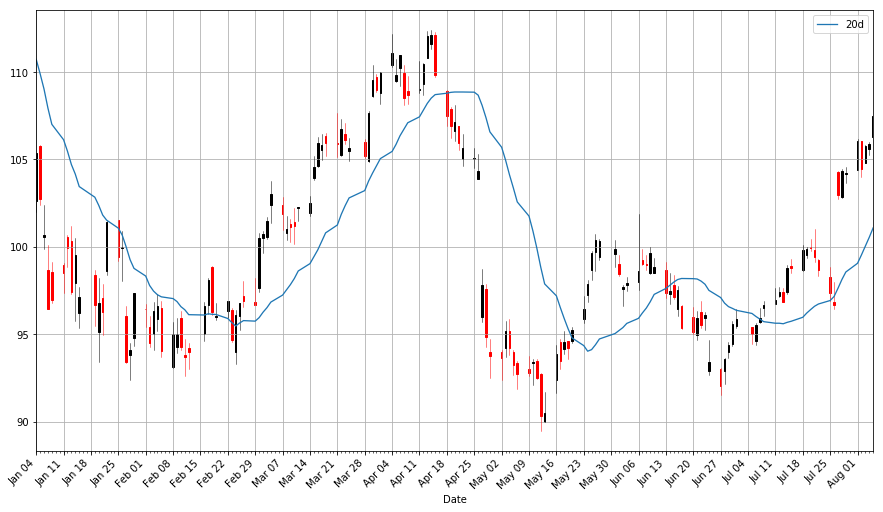

In [13]:
start = datetime.datetime(2010,1,1)
apple = web.DataReader("AAPL", "yahoo", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

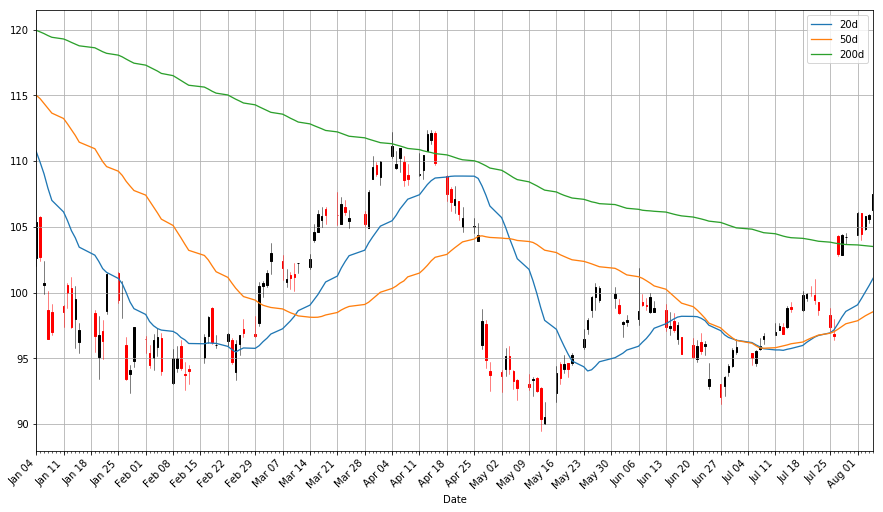

In [14]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])

In [15]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Adj Close,Volume,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2018-02-07,163.089996,163.399994,159.070007,159.539993,158.892166,51608600,171.01,171.76,159.72,-0.75
2018-02-08,160.289993,161.000000,155.029999,155.149994,154.520004,54390500,170.06,171.38,159.78,-1.32
2018-02-09,157.070007,157.889999,150.240005,156.410004,156.410004,70672600,169.11,171.04,159.84,-1.93
2018-02-12,158.500000,163.889999,157.509995,162.710007,162.710007,60819500,168.39,170.91,159.93,-2.52
2018-02-13,161.949997,164.750000,161.649994,164.339996,164.339996,32282900,167.80,170.76,160.04,-2.96


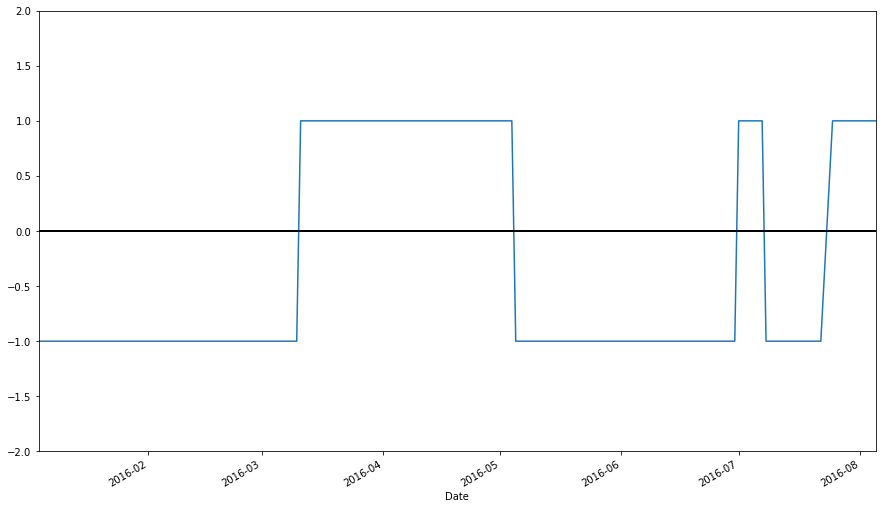

In [16]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-01':'2016-08-07',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)


 1    1299
-1     692
 0      53
Name: Regime, dtype: int64

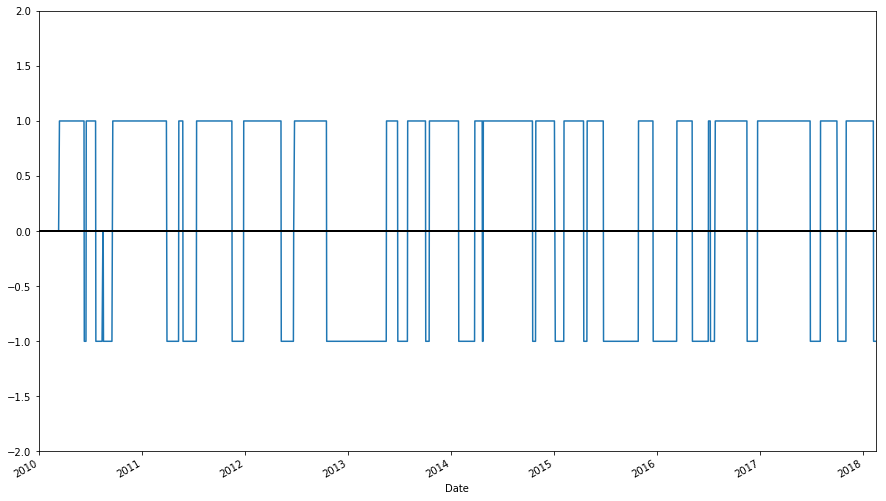

In [18]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)
apple["Regime"].value_counts()

In [19]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

D:\adiarun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
D:\adiarun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sign
  after removing the cwd from sys.path.


,Open,High,Low,Close,Adj Close,Volume,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2018-02-07,163.089996,163.399994,159.070007,159.539993,158.892166,51608600,171.01,171.76,159.72,-0.75,-1.0,0.0
2018-02-08,160.289993,161.000000,155.029999,155.149994,154.520004,54390500,170.06,171.38,159.78,-1.32,-1.0,0.0
2018-02-09,157.070007,157.889999,150.240005,156.410004,156.410004,70672600,169.11,171.04,159.84,-1.93,-1.0,0.0
2018-02-12,158.500000,163.889999,157.509995,162.710007,162.710007,60819500,168.39,170.91,159.93,-2.52,-1.0,0.0
2018-02-13,161.949997,164.750000,161.649994,164.339996,164.339996,32282900,167.80,170.76,160.04,-2.96,-1.0,1.0


 0.0    1994
 1.0      25
-1.0      24
Name: Signal, dtype: int64

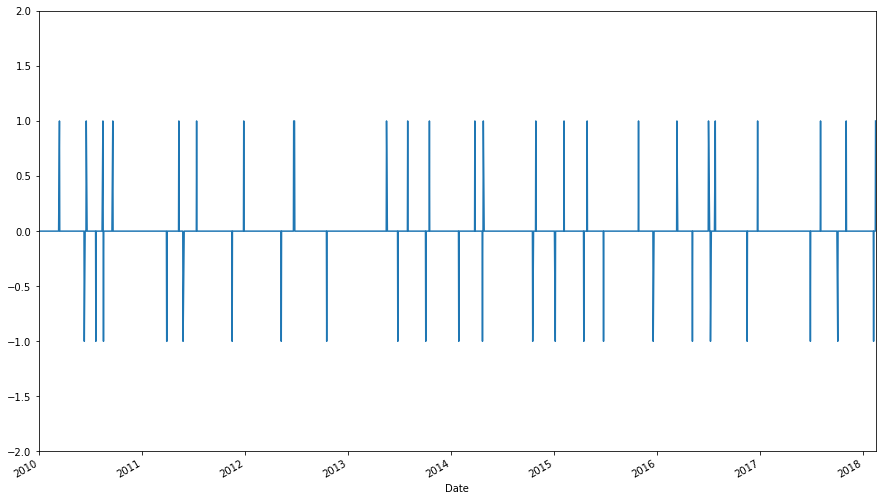

In [21]:
apple["Signal"].plot(ylim = (-2, 2))
apple["Signal"].value_counts()

In [22]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-15,31.977142,1.0,Buy
2010-06-11,36.215714,-1.0,Sell
2010-06-18,39.152859,1.0,Buy
2010-07-22,37.002857,-1.0,Sell
2010-08-16,35.377144,0.0,Buy
2010-08-18,36.152859,-1.0,Sell
2010-09-20,40.461430,1.0,Buy
2011-03-30,49.804287,0.0,Sell
2011-03-31,49.787144,-1.0,Sell


ValueError: array length 22 does not match index length 23

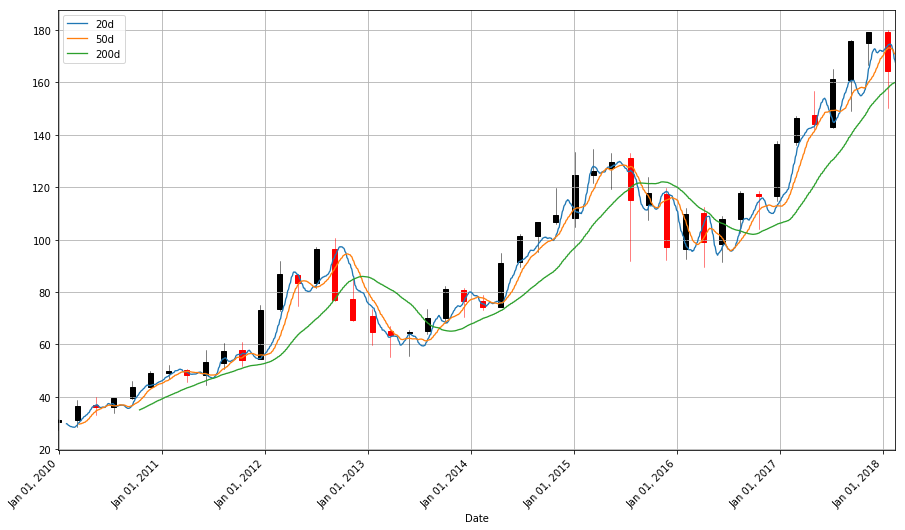

In [27]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

In [38]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 

apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)

D:\adiarun\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
D:\adiarun\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sign


In [44]:
# apple_adj_signals
Price=apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"]
Profit=pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist()
End_Date=apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index

In [51]:
print(len(Price),len(Profit),len(End_Date))

apple_adj_long_profits = pd.DataFrame({
        "Price":Price[:-1],
        "Profit": Profit
    ,"End Date": End_Date
    })
apple_signals

24 23 23


,Price,Regime,Signal
Date,,,
2010-03-15,31.977142,1.0,Buy
2010-06-11,36.215714,-1.0,Sell
2010-06-18,39.152859,1.0,Buy
2010-07-22,37.002857,-1.0,Sell
2010-08-16,35.377144,0.0,Buy
2010-08-18,36.152859,-1.0,Sell
2010-09-20,40.461430,1.0,Buy
2011-03-30,49.804287,0.0,Sell
2011-03-31,49.787144,-1.0,Sell


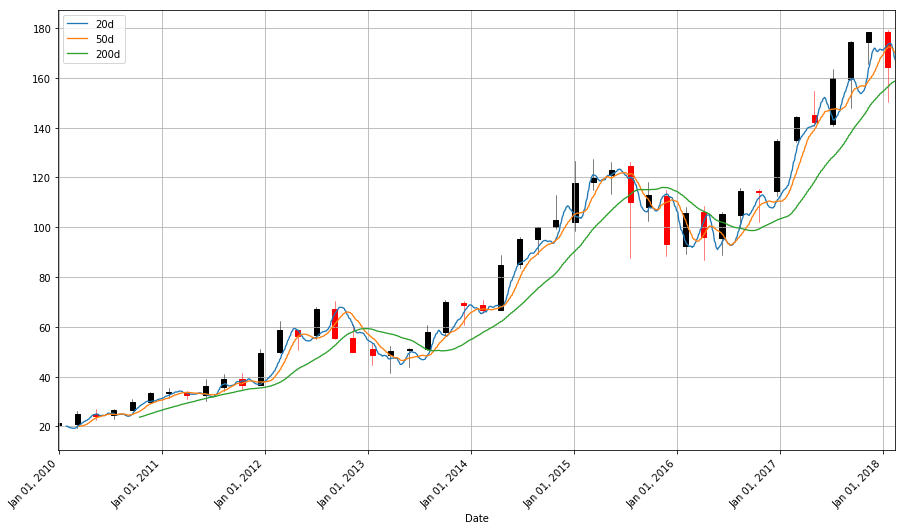

In [50]:
# apple_adj_long_profits = pd.DataFrame({
#         "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
#                                   apple_adj_signals["Regime"] == 1, "Price"],
#         "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
#             apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
#         ].tolist(),
#         "End Date": apple_adj_signals["Price"].loc[
#             apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
#         ].index
#     })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])